# Código en Python - Anisotropías en H_0 para datos de NED

## Análisis de chi-cuadrado/Monte Carlo

En esta parte hallaremos las coordenadas del vector dipolo que minimiza el chi-cuadrado, para hallar la variación máxima entre valores de $!H_{0i}$. $!H_0$ es el valor medio encontrado con el [ajuste lineal inicial](anisotropias.ipynb).


$$\chi^2=\sum_i\left(\frac{\left(\frac{z_i}{D_i}-!H_0\right)-(n_{xi}D_x+n_{yi}D_y+n_{zi}D_z)}{\sigma_{i,sw}}\right)^2$$

Aquí $\sigma_{i,sw}$ es el peso estadístico.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

Definimos la función chi-cuadrado.

In [29]:
def chi2(x):
    dp2=nx*x[0]+ny*x[1]+nz*x[2]
    return np.sum(((h0-b0-dp2)/eps)**2.) 

In [30]:
r2d = 57.295779513082321
c_kmsec = 299792.458
niter=10000 # Iteraciones

Alistamos el archivo de salida, y con pandas abrimos los datos originales de NED y los del ajuste lineal [Monte Carlo](anisotropias).


In [31]:
fout = open("optimization.txt","w")
fout.write("%s,%s,%s,%s\n" % ('Col','Dx','Dy','Dz'))
df = pd.read_csv('nedpaper.csv', index_col=0)
dfmc=pd.read_csv('fitresults.txt', index_col=0)

Cambio de coordenadas galácticas a $\theta,\phi$.

In [32]:
theta=(90.-df.Glat)/r2d
phi=df.Glon/r2d

Errores para Monte Carlo.

In [33]:
sigx=df.dis_d
sigy=df.zz_d

Construimos el vector unitario de cada galaxia

In [34]:
nx=np.sin(theta)*np.cos(phi)
ny=np.sin(theta)*np.sin(phi)
nz=np.cos(theta)

Leemos los parámetros del ajuste lineal Monte Carlo.

In [35]:
b0=np.mean(dfmc.BMC)
a0=np.mean(dfmc.AMC)

El peso estadístico del ajuste inicial lo definimos según la propagación del error para $!H_0i=z_i/D_i$. Esto es válido sólo si la distribución de $!H_0$ es gaussiana. 

$$\sigma_{i,sw}=\sqrt{\left(\frac{\sigma_{z,i}}{D_i}\right)^2+\left(\frac{\sigma_{D,i}\cdot z_i}{D_i^2}\right)^2}$$

In [36]:
eps=np.sqrt((sigy/df.dis)**2+(sigx*df.zz/(df.dis**2))**2)
znew=df.zz # Aquí iría una posible corrección por un bias, p. ej. el punto de corte en el ajuste
h0=znew/df.dis

Damos una primera estimación para las coordenadas del dipolo (x0) y hacemos una primera minimización del chi-cuadrado con el método Nelder-Mead, que no es particularmente eficiente pero es robusto. El resultado de la primera minimización (res.x) lo usamos como estimación para los siguientes ajustes.

In [37]:
x0 = np.array([1., 1., 1.])
res = minimize(chi2, x0, method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
# Help subsequent optimization calls with initial guess (before 2nd Monte Carlo)
x0=res.x

Optimization terminated successfully.
         Current function value: 631.805904
         Iterations: 134
         Function evaluations: 245


La minimización del chi-cuadrado con Monte Carlo se basa en aleatorizar el valor de $!H_0$ en base a los errores en z,D. Las opciones para la elección del peso estadístico están comentadas. Este procedimiento puede tomar de 30-90 minutos.

In [ ]:
for k in range (1,niter):
    zzran = np.random.normal(df.zz,df.zz_d)
    disran=np.random.normal(df.dis,df.dis_d)
    x=disran
    y=zzran
    h0=y/x
#    Opciones para el peso estadístico    
#    eps=np.sqrt((sigy/x)**2+(sigx*y/(x**2))**2) # Usando valores Monte Carlo de z,D
#    eps=1. # Sin peso estadístico
#    sigx,sigy=(0.06*df.dis),(0.02*df.zz) # Ajustando los errores según el paper. Esta línea se usa junto con la siguiente.
    eps=np.sqrt((sigy/df.dis)**2+(sigx*df.zz/(df.dis**2))**2) # Usando directamente los valores de z,D
    res = minimize(chi2, x0, method='nelder-mead',options={'xtol': 1e-8})
    fout.write("%d, %s, %s, %s\n" % (k,res.x[0],res.x[1],res.x[2]))
    print k,res.fun # Se deja esta opción para que muestre el progreso del programa.
fout.close()

Ahora vamos a visualizar los resultados con ayuda de pylab.

In [2]:
%pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = 12, 8

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


Abrimos el archivo con los resultados de la minimización Monte Carlo, y obtenemos la dirección del dipolo de cada ajuste. Este ángulo lo podemos comparar con el ángulo del dipolo obtenido en el paper, cuyas coordenadas son DSx, DSy, DSz. Una medida de la dispersión que produce el método es $\sigma_q$, que es la desviación estándar angular por cuadratura.

In [5]:
dfopt=pd.read_csv('optimization_mc_errors_bias_Dh_35Mpc.txt', index_col=0)
dhip=np.sqrt(dfopt.Dx**2+dfopt.Dy**2+dfopt.Dz**2)
thangle=np.arccos(dfopt.Dz/dhip)*r2d
phangle=np.arctan2(dfopt.Dy,dfopt.Dx)*r2d
sigmaq=np.sqrt(np.std(thangle)**2+np.std(phangle)**2)
DSx=3.3
DSy=-2.4
DSz=-1.4
dhpaper=np.sqrt(DSx**2+DSy**2+DSz**2)
thpaper=np.arccos(DSz/dhpaper)*r2d
phpaper=np.arctan2(DSy,DSx)*r2d

Graficamos el histograma 2D para la dirección del dipolo de cada ajuste.

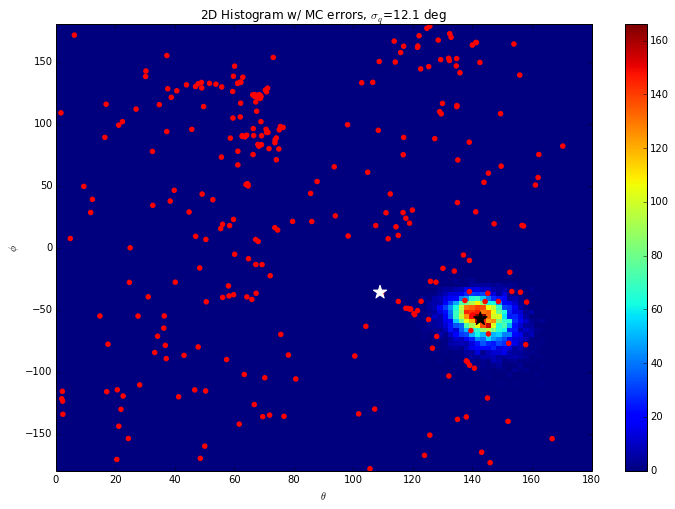

In [39]:
range=np.array([(0,180),(-180,180)])
plt.hist2d(thangle,phangle,bins=100,range=range)
colorbar()
plt.scatter(theta*r2d,phi*r2d-180,color='red') # Ver la distribución angular de las galaxias
plt.scatter(mean(thangle),mean(phangle),color='black',s=200,marker='*') # Ver el promedio de los ángulos
plt.scatter(thpaper,phpaper,color='white',s=200,marker='*')
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\phi$")
plt.title("2D Histogram w/ MC errors, $\sigma_q$=%d.1 deg" % (sigmaq))
plt.show()